# Comparing different model metrics

In [1]:
# import the libraries and tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# store the data frame in a variable
df = pd.read_csv('C:\\dev\\lung_cancer_analysis\\lung_cancer_data.csv')

# convert YES and NO values to numerical binary values 1 and 0 ( feature encoding also known as binary-encoding/label-encoding)
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})


# Separate features and target variable
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48, stratify=y)

# Verify the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=48, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=48),
    "Random Forest": RandomForestClassifier(random_state=48),
    "Gradient Boosting": GradientBoostingClassifier(random_state=48),
    "SVM": SVC(probability=True, random_state=48),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Dictionary to store model performances
model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # Calculate evaluation metrics
    performance = {
        "Accuracy": round(accuracy_score(y_test, y_pred) * 100, 2),
        "Recall": round(recall_score(y_test, y_pred) * 100, 2), 
        "F1 Score": round(f1_score(y_test, y_pred) * 100, 2),
        "Precision": round(precision_score(y_test, y_pred) * 100, 2),
        "ROC-AUC": round(roc_auc_score(y_test, y_prob) * 100, 2)
    }
    
    # Store the performance
    model_performance[model_name] = performance

# Convert performance dictionary to a DataFrame for easier comparison
performance_df = pd.DataFrame(model_performance).T
performance_df.sort_values(by="ROC-AUC", ascending=True)

,Accuracy,Recall,F1 Score,Precision,ROC-AUC
Naive Bayes,90.79,95.88,94.79,93.72,91.99
SVM,87.37,100.00,93.26,87.37,93.24
Logistic Regression,87.51,86.83,92.39,98.71,94.78
Gradient Boosting,97.53,98.87,98.59,98.31,99.43
Random Forest,99.60,99.54,99.77,100.00,100.00
Decision Tree,99.60,99.54,99.77,100.00,100.00
KNN,99.73,100.00,99.85,99.69,100.00


# Cross validating the models

In [2]:
# Number of folds for cross-validation
n_folds = 6

# Perform cross-validation for each model and store fold-wise performance with the mean
six_fold_performance = {}

for model_name, model in models.items():
    # Perform cross-validation and store scores for each fold
    cv_scores = cross_val_score(model, X, y, cv=n_folds, scoring='roc_auc')
    six_fold_performance[model_name] = {
        f"Fold {i+1}": round(score * 100, 2) for i, score in enumerate(cv_scores)
    }
    # Add the mean ROC-AUC for the model
    six_fold_performance[model_name]["Mean ROC-AUC"] = round(cv_scores.mean() * 100, 2)

# Convert six-fold performance to a DataFrame
six_fold_performance_df = pd.DataFrame(six_fold_performance).T
six_fold_performance_df


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Mean ROC-AUC
Logistic Regression,94.64,94.64,94.64,94.64,94.64,94.64,94.64
Decision Tree,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Random Forest,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Gradient Boosting,99.56,99.56,99.56,99.56,99.56,99.56,99.56
SVM,92.67,92.67,92.67,92.67,92.67,92.67,92.67
KNN,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Naive Bayes,91.08,91.08,91.08,91.08,91.08,91.08,91.08


# Linear-Regression model 

------------------------------------------------------------------------------------------------------
Accuracy:     92.53932584269663 %
Recall Score: 98.10450819672131 %
Precision:    93.68884540117418 %
F1-score:     95.84584584584584 %
ROC-AUC:      94.12512009848075 %
Cross-validation scores: [0.93533487 0.91098266 0.91560694 0.90982659 0.91213873 0.92023121]
Mean Cross-Validation Score: 0.9173535000244742
------------------------------------------------------------------------------------------------------


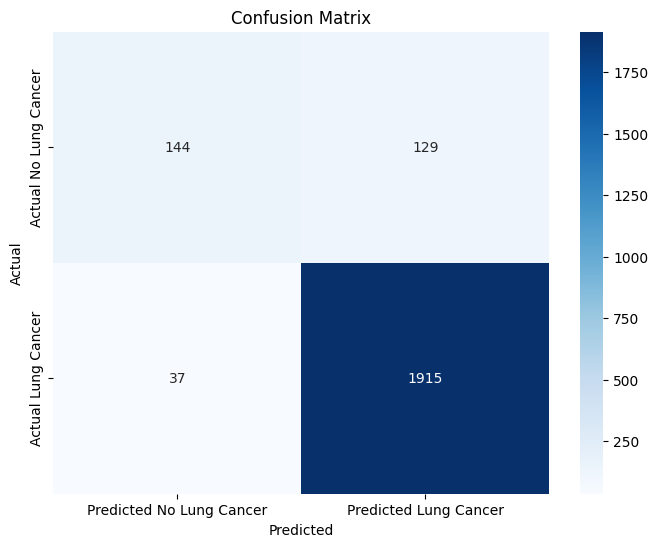

In [3]:
# Define features (X) and target variable (y)
X = df.drop(columns=['LUNG_CANCER'])
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

print('------------------------------------------------------------------------------------------------------')

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate ROC-AUC if supported by the model
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test))

# Print metrics
print("Accuracy:    ", accuracy * 100, "%")
print("Recall Score:", recall * 100, "%")
print("Precision:   ", precision * 100, "%")
print("F1-score:    ", f1 * 100, "%")
print("ROC-AUC:     ", roc_auc * 100, "%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

print('------------------------------------------------------------------------------------------------------')

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Lung Cancer', 'Predicted Lung Cancer'],
            yticklabels=['Actual No Lung Cancer', 'Actual Lung Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Improving the metrics on the Linear-Regression model 

------------------------------------------------------------------------------------------------------
Accuracy:     95.4177897574124 %
Recall Score: 99.07692307692308 %
Precision:    95.83333333333334 %
F1-score:     97.42813918305598 %
ROC-AUC:      96.65551839464884 %
Cross-validation scores: [0.93021277 0.92163543 0.9241908  0.92248722 0.91567291 0.92248722]
Mean Cross-Validation Score: 0.9227810600843332
------------------------------------------------------------------------------------------------------


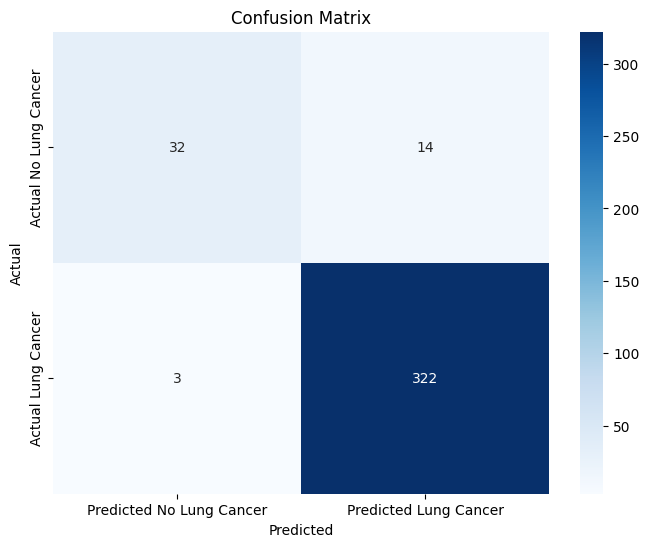

In [4]:
# removed certain parameters to have smaller feature columns
df = df.drop(['YELLOW_FINGERS', 'SWALLOWING_DIFFICULTY', 'SMOKING'], axis=1)

# change the test size and random state to find the best accuracy score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=3)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

print('------------------------------------------------------------------------------------------------------')

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate ROC-AUC if supported by the model
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = roc_auc_score(y_test, model.decision_function(X_test))

# Print metrics
print("Accuracy:    ", accuracy * 100, "%")
print("Recall Score:", recall * 100, "%")
print("Precision:   ", precision * 100, "%")
print("F1-score:    ", f1 * 100, "%")
print("ROC-AUC:     ", roc_auc * 100, "%")

# Perform 6-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

print('------------------------------------------------------------------------------------------------------')

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Lung Cancer', 'Predicted Lung Cancer'],
            yticklabels=['Actual No Lung Cancer', 'Actual Lung Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [5]:
# Check the balance of the target variable (LUNG_CANCER)
class_distribution = y.value_counts(normalize=True) * 100

# Display class distribution as text
class_distribution


LUNG_CANCER
1    87.378641
0    12.621359
Name: proportion, dtype: float64